In [4]:
!pip install py_vollib

In [5]:
!pip install pandas_datareader

In [6]:
!pip install yfinance

In [1]:
# import pandas_datareader.data as reader
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
# import math
import numpy as np
# import pandas as pd
# import scipy.stats as stats
import yfinance as yf
import plotly.colors
import plotly.graph_objects as go
import seaborn as sns

# from scipy.stats import norm # type: ignore

**Example User Inputs**

In [2]:
example_stocks=['AAPL', 'GOOGL', 'MSFT'] 

In [3]:
now = dt.datetime.now()
starting = now - dt.timedelta(days=100)

**STORING STOCKS DATA:** StockData Class

In [4]:
class StockData:
    def __init__(self, stock_list, 
                 start_date=dt.datetime.now() - dt.timedelta(days=100), 
                 end_date=dt.datetime.now(), 
                 weights=None):
        self.stocks = stock_list
        self.start = start_date
        self.end = end_date
        self.mean_returns, self.cov_matrix, self.corr_matrix = self.get_data()

        self.stock_num = len(self.mean_returns)
        if weights is not None:
            if len(weights) != len(stock_list):
                raise ValueError("Weights do not match the number of stocks inputted.")
            self.weights = weights
        else:
            self.weights = self.set_weights()
    
    def get_data(self):
        df = yf.download(self.stocks, self.start, self.end)
        print(df)
        df_close = df["Close"]
        print(df_close)
        returns = df_close.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        corr_matrix = returns.corr()
        return mean_returns, cov_matrix, corr_matrix 
    
    def set_weights(self):
        weights = np.random.random(self.stock_num)
        weights /= np.sum(weights)
        return weights


**MONTE CARLO SIMULATION:** MonteCarlo Class

In [ ]:
class MonteCarlo:    
    def __init__(self, stock_data: StockData, num_simulations = 100, timeframe = 100, initial_portfolio = 10000):
        if not isinstance(stock_data, StockData):
            raise TypeError("Expected an instance of the StockData class.")
        self.stock_data = stock_data
        self.stock_num = self.stock_data.stock_num
        self.num_sim = num_simulations
        self.time = timeframe
        self.init_port = initial_portfolio
        self.sims_matrix = self.create_simulation_matrix()
        self.final_values = self.sims_matrix[-1]

    def corr_heatmap(self):
        plt.figure(figsize=(8,8))
        sns.heatmap(self.stock_data.corr_matrix, annot = True, fmt=".2f", cmap="coolwarm", square=True,
                    xticklabels=self.stock_data.stocks,
                    yticklabels=self.stock_data.stocks,
                    vmin=-1, 
                    vmax=1,
                    cbar_kws={'label': 'Correlation Coefficient'} )
        plt.title("Stock Correlation Matrix")
        plt.show()

    def create_simulation_matrix(self):
        mean_matrix = np.full(shape = (self.time, self.stock_num), fill_value=self.stock_data.mean_returns)
        mean_matrix = mean_matrix.T #transpose of matrix
        sims_matrix = np.full(shape = (self.time, self.num_sim), fill_value=0.0)

        for m in range (0, self.num_sim):
            Z = np.random.normal(size = (self.time, self.stock_data.stock_num)) #random normal dist
            L = np.linalg.cholesky(self.stock_data.cov_matrix) #lower triangular matrix of cholesky decomposition
            daily_returns = mean_matrix + np.inner(L, Z)
            sims_matrix[:, m] = np.cumprod(np.inner(self.stock_data.weights, daily_returns.T)+1)*self.init_port
        return sims_matrix
    
    def plot_simulation_lines(self):
        days = list(range(self.sims_matrix.shape[0]))  # X-axis for days
        
        # Create a Plotly figure
        fig = go.Figure()

        color_scale = plotly.colors.sample_colorscale("Spectral", np.linspace(0, 1, self.sims_matrix.shape[1]))


        for i in range(self.sims_matrix.shape[1]):
            fig.add_trace(go.Scatter(
                x=days,
                y=self.sims_matrix[:, i],
                mode='lines',
                line=dict(color=color_scale[i], width=1.5),
                showlegend=False,
                hoverinfo="skip" 
            ))

        fig.update_layout(
            title="Monte Carlo Simulations",
            xaxis_title="Days",
            yaxis_title="Portfolio Value (USD)",
            yaxis=dict(range=[self.sims_matrix.min()-100, self.sims_matrix.max()+100]),
            template="plotly_white"
        )
        fig.show()

    
    def plot_simulation_avg(self):
        average_values = np.mean(self.sims_matrix, axis=1)  # Mean across simulations at each day
        days = list(range(len(average_values)))
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=days,
            y=average_values,
            mode='lines+markers',
            name='Average Portfolio Value',
            line=dict(color='blue'),
            hovertemplate="Day: %{x}<br>Value: $%{y:.2f}<extra></extra>"
        ))
        fig.add_annotation(
            x=days[-1], 
            y=average_values[-1],
            text=f"End Value: ${average_values[-1]:.2f}",
            showarrow=True,
            arrowhead=2,
            ax=-50, ay=-40
        )
        fig.update_layout(
            title="Average Simulated Portfolio Value",
            xaxis_title="Days",
            yaxis_title="Portfolio Value (USD)",
            yaxis=dict(range=[self.sims_matrix.min()-100, self.sims_matrix.max()+100]),
            template="plotly_white"
        )
        fig.show()
        
    def plot_histogram_with_risk_metrics(self):
        # Calculate histogram data
        hist_data = np.histogram(self.final_values, bins=30)

        # Calculate VaR and CVaR
        VaR_5 = np.percentile(self.final_values, 5)
        CVaR_5 = self.final_values[self.final_values <= VaR_5].mean()

        fig = go.Figure()

        fig.add_trace(go.Histogram(
            x=self.final_values,
            nbinsx=30,
            marker=dict(color="skyblue", line=dict(color="black", width=1)),
            opacity=0.7,
            name="Final Portfolio Value"
        ))

        # Add VaR and CVaR lines
        fig.add_vline(x=VaR_5, line=dict(color="red", dash="dash"), name=f'VaR (5%): ${VaR_5:.2f}')
        fig.add_vline(x=CVaR_5, line=dict(color="orange", dash="dash"), name=f'CVaR (5%): ${CVaR_5:.2f}')

        # Update layout for clarity and add annotation for VaR and CVaR
        fig.update_layout(
            title="Histogram of Final Portfolio Values with VaR and CVaR",
            xaxis_title="Final Portfolio Value",
            yaxis_title="Frequency",
            template="plotly_white"
        )
        fig.add_annotation(
            x=VaR_5, 
            y=max(hist_data[0])/2,  # Position the annotation near the histogram peak
            text=f"VaR (5%): ${VaR_5:.2f}",
            showarrow=True,
            arrowhead=2,
            ax=40, ay=-40
        )
        fig.add_annotation(
            x=CVaR_5, 
            y=max(hist_data[0])/3,  # Position the annotation near the histogram peak
            text=f"CVaR (5%): ${CVaR_5:.2f}",
            showarrow=True,
            arrowhead=2,
            ax=40, ay=-40
        )
        fig.show()
    def display_risk_metrics_table_with_insights(self):
        # Calculate risk metrics
        std_dev = np.std(self.final_values)
        mean_return = np.mean(self.final_values)
        sharpe_ratio = (mean_return - self.init_port) / std_dev

        # Generate insights
        insights = []
        if std_dev < 1000:
            insights.append("Low portfolio volatility indicates stable performance.")
        elif std_dev < 2000:
            insights.append("Moderate portfolio volatility; keep an eye on market conditions.")
        else:
            insights.append("High portfolio volatility; diversification might reduce risk.")

        if sharpe_ratio > 1:
            insights.append("Excellent risk-adjusted returns; the portfolio is performing well.")
        elif sharpe_ratio > 0.5:
            insights.append("Decent risk-adjusted returns; consider small optimizations.")
        else:
            insights.append("Low risk-adjusted returns; revisit strategy or rebalance.")

        # Create the table for metrics
        fig, ax = plt.subplots()
        ax.axis('tight')
        ax.axis('off')
        table_data = [
            ["Metric", "Value"],
            ["Standard Deviation", f"${std_dev:.2f}"],
            ["Mean Final Value", f"${mean_return:.2f}"],
            ["Sharpe Ratio", f"{sharpe_ratio:.2f}"]
        ]
        table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.5, 1.5)
        plt.title("Risk Metrics Summary with Insights")
        
        # Add insights as annotations
        for i, insight in enumerate(insights, start=1):
            plt.figtext(0.5, 0.1 - (i * 0.05), f"{i}. {insight}", wrap=True, horizontalalignment='center', fontsize=10)

        plt.show()




[*********************100%***********************]  3 of 3 completed


Price                       Adj Close                               Close  \
Ticker                           AAPL        GOOG        MSFT        AAPL   
Date                                                                        
2023-11-27 00:00:00+00:00  188.864761  137.711807  375.799805  189.789993   
2023-11-28 00:00:00+00:00  189.471771  138.280396  379.859497  190.399994   
2023-11-29 00:00:00+00:00  188.446793  136.065842  376.037994  189.369995   
2023-11-30 00:00:00+00:00  189.023956  133.591919  376.097595  189.949997   
2023-12-01 00:00:00+00:00  190.307693  132.993408  371.730225  191.240005   
...                               ...         ...         ...         ...   
2024-11-18 00:00:00+00:00  228.020004  176.800003  414.929474  228.020004   
2024-11-19 00:00:00+00:00  228.279999  179.580002  416.955414  228.279999   
2024-11-20 00:00:00+00:00  229.000000  177.330002  414.659973  229.000000   
2024-11-21 00:00:00+00:00  228.520004  169.240005  412.869995  228.520004   

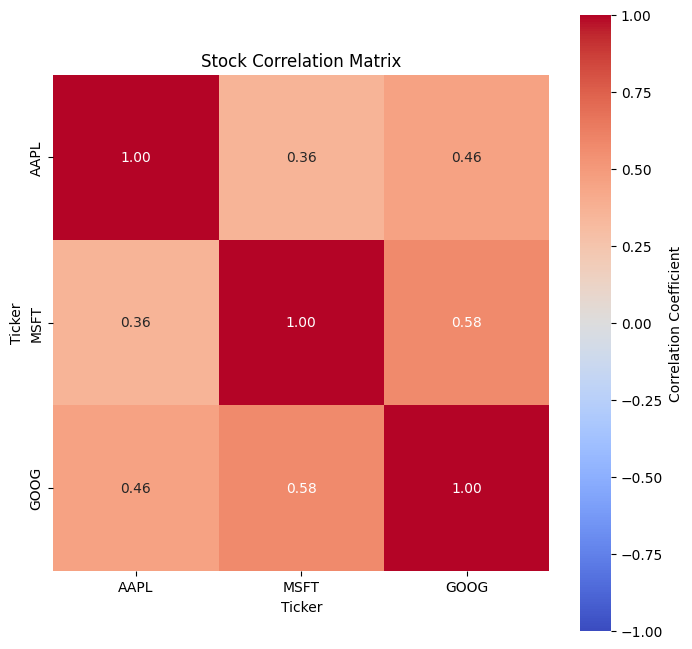

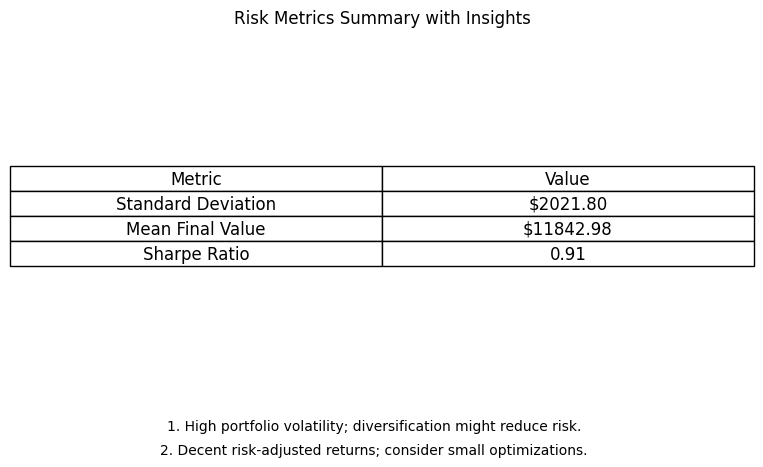

In [ ]:
from datetime import datetime, timedelta

# Initialize the StockData class
stock_symbols = ['AAPL', 'MSFT', 'GOOG']  # Replace with any valid stock symbols
start_date = datetime.now() - timedelta(days=365)  # Data from the last year
stock_data = StockData(stock_list=stock_symbols, start_date=start_date)

# Print the data to verify it works
print("Mean Returns:", stock_data.mean_returns)
print("Covariance Matrix:", stock_data.cov_matrix)
print("Correlation Matrix:", stock_data.corr_matrix)

# Initialize the MonteCarlo class
monte_carlo = MonteCarlo(stock_data=stock_data, num_simulations=100, timeframe=252)

# Call methods from the MonteCarlo class
monte_carlo.plot_simulation_lines()  # Plot simulation results
monte_carlo.plot_simulation_avg()   # Plot average portfolio value
monte_carlo.corr_heatmap()          # Display correlation heatmap

monte_carlo.plot_histogram_with_risk_metrics()
monte_carlo.display_risk_metrics_table_with_insights()